In [14]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [16]:


# File paths (adjusted for your setup)
train_path = r"C:\Users\adnan\Desktop\offensivelang\mal_full_offensive_train (1).csv"
dev_path = r"C:\Users\adnan\Desktop\offensivelang\mal_full_offensive_dev.csv"

# Load CSV files
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

# Preview
print("Train samples:", len(train_df))
print("Validation samples:", len(dev_df))
train_df.head()


Train samples: 16010
Validation samples: 1999


,Text,Labels
0,പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ് അല്ലാതെ സ്വന്ത...,Not_offensive
1,ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...,Not_offensive
2,ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...,Not_offensive
3,Sushin syam Shaiju khalid Midhun manual,Not_offensive
4,J A K E S. B EJ O Y !!!,Not_offensive


In [17]:
from transformers import DistilBertTokenizerFast

# Load Multilingual DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')

# Example test
example_text = train_df['Text'][0]
print("Original text:", example_text)
print("Tokenized output:", tokenizer(example_text))


Original text: പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ്  അല്ലാതെ  സ്വന്തം രാജവയത് അല്ല
Tokenized output: {'input_ids': [101, 65019, 57386, 119, 65019, 96073, 1331, 23290, 29400, 13622, 1359, 24458, 111388, 57371, 1321, 37591, 24458, 58167, 1367, 24164, 36877, 43877, 36655, 1359, 24458, 111388, 36877, 18395, 17676, 1321, 37591, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [18]:
label_column = 'Labels'

label_mapping = {
    'Not_offensive': 1,
    'not-malayalam': 2,
    'Offensive_Targeted_Insult_Individual': 0,
    'Offensive_Targeted_Insult_Group': 0,
    'Offensive_Untargetede': 0
}

train_df['label_id'] = train_df[label_column].map(label_mapping)
dev_df['label_id'] = dev_df[label_column].map(label_mapping)

print(train_df[['Text', label_column, 'label_id']].head())
print(train_df['label_id'].value_counts())


                                                Text         Labels  label_id
0  പലദേശം. പല ഭാഷ ഒരേ ഒരു രാജാവ്  അല്ലാതെ  സ്വന്ത...  Not_offensive         1
1  ഈ ഓണം ഏട്ടനും പിള്ളേർക്ക് ഉള്ളതാണ് എന്ന് ഉള്ളവ...  Not_offensive         1
2  ആരണ്ട ആരണ്ട തലുണ്ടാകാണാ ആരണ്ട ഞാൻ ആണ്ട ഞാൻ ആണ്...  Not_offensive         1
3          Sushin syam  Shaiju khalid  Midhun manual  Not_offensive         1
4                          J A K E S.   B EJ O Y !!!  Not_offensive         1
label_id
1    14153
2     1287
0      570
Name: count, dtype: int64


In [19]:
from transformers import AutoModel

model = AutoModel.from_pretrained('distilbert-base-multilingual-cased')
model.to(device)
model.eval()  # set model to evaluation mode


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): 

In [22]:
import numpy as np
from tqdm import tqdm

def get_embeddings(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            # CLS token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

train_embeddings = get_embeddings(train_df['Text'].tolist())
dev_embeddings = get_embeddings(dev_df['Text'].tolist())

print("Train embeddings shape:", train_embeddings.shape)
print("Dev embeddings shape:", dev_embeddings.shape)


100%|██████████| 63/63 [02:11<00:00,  2.09s/it]

Train embeddings shape: (16010, 768)
Dev embeddings shape: (1999, 768)


In [23]:
# Save embeddings to .npy files (so you can reuse them later)
np.save("train_embeddings.npy", train_embeddings)
np.save("dev_embeddings.npy", dev_embeddings)


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, train_df['label_id'])

# Predict on dev set
dev_preds = knn.predict(dev_embeddings)

# Evaluate
print("Accuracy:", accuracy_score(dev_df['label_id'], dev_preds))
print("Classification Report:\n", classification_report(dev_df['label_id'], dev_preds))


Accuracy: 0.9094547273636818
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.14      0.19        57
           1       0.92      0.98      0.95      1779
           2       0.84      0.39      0.53       163

    accuracy                           0.91      1999
   macro avg       0.68      0.50      0.56      1999
weighted avg       0.90      0.91      0.89      1999



In [25]:
X_train = train_embeddings
y_train = train_df['label_id'].values

X_dev = dev_embeddings
y_dev = dev_df['label_id'].values


In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_dev)

print("Random Forest Accuracy:", accuracy_score(y_dev, rf_preds))
print("Classification Report (Random Forest):")
print(classification_report(y_dev, rf_preds))


Random Forest Accuracy: 0.9589794897448725
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.93      0.49      0.64        57
           1       0.96      1.00      0.98      1779
           2       0.98      0.70      0.82       163

    accuracy                           0.96      1999
   macro avg       0.96      0.73      0.81      1999
weighted avg       0.96      0.96      0.95      1999



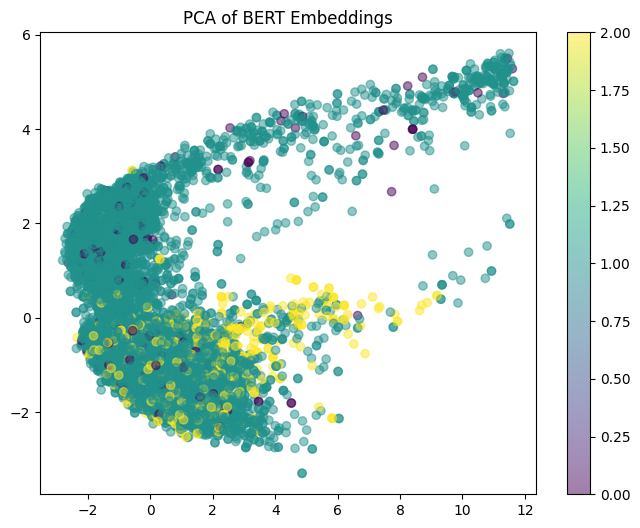

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(train_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=train_df['label_id'], cmap='viridis', alpha=0.5)
plt.title("PCA of BERT Embeddings")
plt.colorbar()
plt.show()


XGBoost Accuracy: 0.9664832416208105
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.94      0.51      0.66        57
           1       0.97      0.99      0.98      1779
           2       0.92      0.85      0.88       163

    accuracy                           0.97      1999
   macro avg       0.94      0.78      0.84      1999
weighted avg       0.97      0.97      0.96      1999



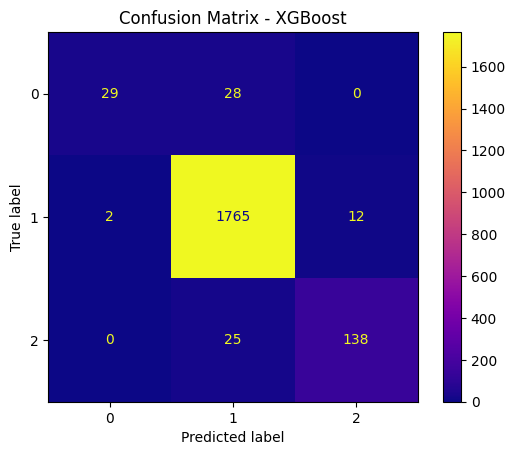

In [29]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Compute balanced sample weights
weights = compute_sample_weight('balanced', y=train_df['label_id'])

# Step 2: Train XGBoost classifier with sample weights
xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(train_embeddings, train_df['label_id'], sample_weight=weights)

# Step 3: Predict on development set
xgb_preds = xgb.predict(dev_embeddings)

# Step 4: Evaluation
print("XGBoost Accuracy:", accuracy_score(dev_df['label_id'], xgb_preds))
print("Classification Report (XGBoost):")
print(classification_report(dev_df['label_id'], xgb_preds))

# Step 5: Confusion Matrix
cm = confusion_matrix(dev_df['label_id'], xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='plasma')
plt.title("Confusion Matrix - XGBoost")
plt.show()



In [30]:
import joblib
joblib.dump(xgb, 'xgboost_offensive_lang.pkl')


['xgboost_offensive_lang.pkl']

In [19]:
# SVM
from sklearn.svm import SVC

svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_dev)

print("SVM Accuracy:", accuracy_score(y_dev, svm_preds))
print("Classification Report (SVM):")
print(classification_report(y_dev, svm_preds))


SVM Accuracy: 0.7343671835917959
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.09      0.70      0.17        57
           1       0.98      0.72      0.83      1779
           2       0.55      0.94      0.69       163

    accuracy                           0.73      1999
   macro avg       0.54      0.79      0.56      1999
weighted avg       0.92      0.73      0.80      1999



In [5]:
train_embeddings = np.load("train_embeddings.npy")


In [20]:
import joblib

# Save the model
joblib.dump(rf, 'random_forest_offensive_lang.pkl')

# Save the tokenizer (optional, for later use)
tokenizer.save_pretrained('saved_tokenizer')


('saved_tokenizer\\tokenizer_config.json',
 'saved_tokenizer\\special_tokens_map.json',
 'saved_tokenizer\\vocab.txt',
 'saved_tokenizer\\added_tokens.json',
 'saved_tokenizer\\tokenizer.json')

In [32]:
import joblib
import torch
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertModel

# Load trained XGBoost model
model = joblib.load('xgboost_offensive_lang.pkl')

# Load tokenizer and BERT model
tokenizer = DistilBertTokenizerFast.from_pretrained('saved_tokenizer')
bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
bert.eval()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert = bert.to(device)

# Get embedding of input text
def get_embedding(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = bert(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
    return embedding

# Predict the class label
def predict(text):
    embedding = get_embedding(text)
    pred = model.predict(embedding)[0]
    label_map = {
        0: "Offensive",
        1: "Not_offensive",
        2: "Not Malayalam"
    }
    return label_map[pred]

# --- Sample run ---
sample_text = "ഇത് വളരെ മോശമായ ഒരു അഭിപ്രായമാണ്"
print("Sample Prediction:", predict(sample_text))

# --- User input loop ---
if __name__ == "__main__":
    while True:
        user_input = input("Enter a Malayalam sentence (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Exiting...")
            break
        result = predict(user_input)
        print(f"Prediction: {result}\n")


Sample Prediction: Not_offensive
Prediction: Not_offensive

Exiting...


In [33]:
import pandas as pd

test_df = pd.read_csv('mal_offensive_test_without_labels.csv')
print(test_df.head())


          ID                                               Text
0  ML_OLI_01  അപ്പൊ ഇതൊരൊന്നൊരാ മൊതലാണല്ലേ  Suraj ആണ് നടൻ ന്...
1  ML_OLI_02  എന്ത് ഊള എഡിറ്റിംഗ് ആടോ ഇത് ഒരുമാതിരി vivo vid...
2  ML_OLI_03         Fefka ee padam release cheyyan samadhicho?
3  ML_OLI_04  അആഹാ.. സംഗീതം ജെക്‌സ് ബിജോയ് ആണ് അപ്പൊ പൊട്ടലു...
4  ML_OLI_05  Ravile thane views likes ethra ayyi enn nokan ...


In [1]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')
bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
bert = bert.to(device)
bert.eval()



Using device: cpu


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [4]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["Not_offensive", "Offensive", "Not Malayalam"])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Not_offensive", "Offensive", "Not Malayalam"],
                yticklabels=["Not_offensive", "Offensive", "Not Malayalam"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [35]:
import joblib

xgb_model = joblib.load('xgboost_offensive_lang.pkl')
print("XGBoost model loaded.")


XGBoost model loaded.


In [36]:
import numpy as np
from tqdm import tqdm

def get_embeddings(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)


In [37]:
test_embeddings = get_embeddings(test_df['Text'].tolist())
print("Test embeddings shape:", test_embeddings.shape)


100%|██████████| 63/63 [01:46<00:00,  1.70s/it]

Test embeddings shape: (2001, 768)


In [38]:
test_preds = xgb_model.predict(test_embeddings)
print("Predictions done.")


Predictions done.


In [39]:
label_map = {
    0: "Offensive",
    1: "Not_offensive",
    2: "Not Malayalam"
}

pred_labels = [label_map[p] for p in test_preds]

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'label': pred_labels
})

submission.to_csv('submission.csv', index=False)
print("Submission saved as submission.csv")


Submission saved as submission.csv


In [40]:
submission['label'].value_counts()


label
Not_offensive    1809
Not Malayalam     154
Offensive          38
Name: count, dtype: int64